In [18]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

In [19]:
mu_0 = 1 * units.vacuum_permeability
N = 100
l = 18 * units.millimeter
R = 34 * units.millimeter / 2
I_original = 1 * units.amp
magnet_dipole = 0.0369 * 10 * units.amp * units.meter ** 2
z_space = np.linspace(0 * units.mm, 100 * units.mm, 1000)
m = 6 * units.gram
g = 1 * units.standard_gravity
res = 0.001 * units.ohm
Fg = m * g

class AccurateModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_z_axis = mu_0 * N * I / 2 * (((l / 2 - z) / (l * np.sqrt(R ** 2 + (l / 2 - z) ** 2))) + ((l / 2 + z) / (l * np.sqrt(R ** 2 + (l / 2 + z) ** 2))))
        return B_z_axis
    @classmethod
    def get_F_z_axis(cls, z, I):
        dz = 0.05 * units.mm
        zs = np.linspace(z - dz, z + dz, 2)
        B_z_axis = cls.get_B_z_axis(zs, I)
        dBdz = (B_z_axis[1] - B_z_axis[0]) / dz
        F_z_axis = magnet_dipole * dBdz
        return F_z_axis
    @classmethod
    def get_F_z_axis_as_vector(cls, z, I):
        F_z_axis = np.zeros(np.size(z)) * units.newton
        for idx, z_val in enumerate(z):
            F_z_axis[idx] = cls.get_F_z_axis(z_val, I)
        return F_z_axis
    @classmethod
    def get_lorenz_force(cls, z, dzdt):
        Fl = N * -9 * mu_0 ** 2 * magnet_dipole ** 2 * R ** 4 * z ** 2 * dzdt / (4 * res * (R ** 2 + z ** 2) ** 5)
        return Fl
    @classmethod
    def get_gravity_force(cls):
        Fg = m * g
        return Fg

class ShortSolenoidModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_short_solenoid_eq = mu_0 * I * N * R ** 2 / (2 * (R ** 2 + z ** 2) ** (3 / 2)) # From wikipedia: https://en.wikipedia.org/wiki/Solenoid#Short_solenoid_estimate
        return B_short_solenoid_eq
    @classmethod
    def get_F_z_axis(cls, z, I):
        F_short_solenoid_eq = -3 * mu_0 * R ** 2 * N * I * z / (2 * (R ** 2 + z ** 2) ** (5 / 2)) * magnet_dipole # From: https://www.physicsforums.com/insights/how-to-model-a-magnet-falling-through-a-conducting-pipe/
        return F_short_solenoid_eq

B_z_axis = AccurateModel.get_B_z_axis(z_space, I_original)
F_z_axis = AccurateModel.get_F_z_axis_as_vector(z_space, I_original)
B_short_solenoid_eq = ShortSolenoidModel.get_B_z_axis(z_space, I_original)
F_short_solenoid_eq = ShortSolenoidModel.get_F_z_axis(z_space, I_original)

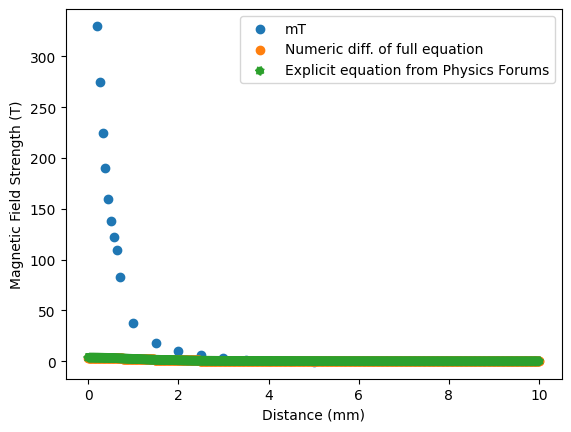

In [20]:
distances = [ # closest to farthest
    0.190909092,
    0.254545456,
    0.31818182,
    0.381818184,
    0.445454545,
    0.509090912,
    0.572727276,
    0.63636364,
    0.700000004,
    1,
    1.5,
    2,
    2.5,
    3,
    3.5,
    4,
    4.5,
    5,
]

mT = [ # closest to farthest, magnet-specific
    330,
    275,
    225,
    190,
    160,
    138.5,
    122,
    109.7,
    83,
    37.24,
    18.3,
    9.8,
    5.88,
    3.27,
    1.31,
    .65,
    0,
    -.65,
 ]

plt.scatter(distances, mT, label = "mT")
plt.xlabel("Distance (units)")
plt.ylabel("Magnetic Field Strength (mT)")
# plt.legend(loc = "lower right")

plt.scatter(z_space.to(units.cm).magnitude, B_z_axis.to(units.millitesla).magnitude, label = "Numeric diff. of full equation")
plt.scatter(z_space.to(units.cm).magnitude, B_short_solenoid_eq.to(units.millitesla).magnitude, linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.xlabel("Distance (mm)")
plt.ylabel("Magnetic Field Strength (T)")
plt.legend(loc = "upper right")